In [95]:
# Install required packages (if not already installed)
!pip install scanpy anndata seaborn scikit-learn --quiet


In [96]:
!pip install torch-geometric -q


In [97]:
# Step 2: Import Libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set visualization style
sns.set_style("whitegrid")


In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Step 3: Load and Preprocess Data
# Define the file path (Change this if needed)
file_path = '/content/drive/MyDrive/GSE155121_human_data_raw.h5ad'

# Load the dataset
adata = sc.read_h5ad(file_path)

# Show basic info
print(adata)
print("Dataset Loaded Successfully!")


AnnData object with n_obs × n_vars = 463304 × 32738
    obs: 'week_stage'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0'
Dataset Loaded Successfully!


In [100]:
# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [101]:
# Normalize and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [102]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

In [103]:
# Scale data
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [104]:
# Display dataset info
print(adata)
print("Data Preprocessing Completed!")

AnnData object with n_obs × n_vars = 462720 × 2000
    obs: 'week_stage', 'n_genes'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
Data Preprocessing Completed!


In [105]:
# Step 4: Exploratory Data Analysis (EDA)
# 1️⃣ Summary of Metadata
print("Available Metadata Columns:", adata.obs.columns)
print("Dataset Overview:")
print(adata.obs.head())


Available Metadata Columns: Index(['week_stage', 'n_genes'], dtype='object')
Dataset Overview:
                                           week_stage  n_genes
index                                                         
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     3476
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     3880
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     4646
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     4258
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1     3743


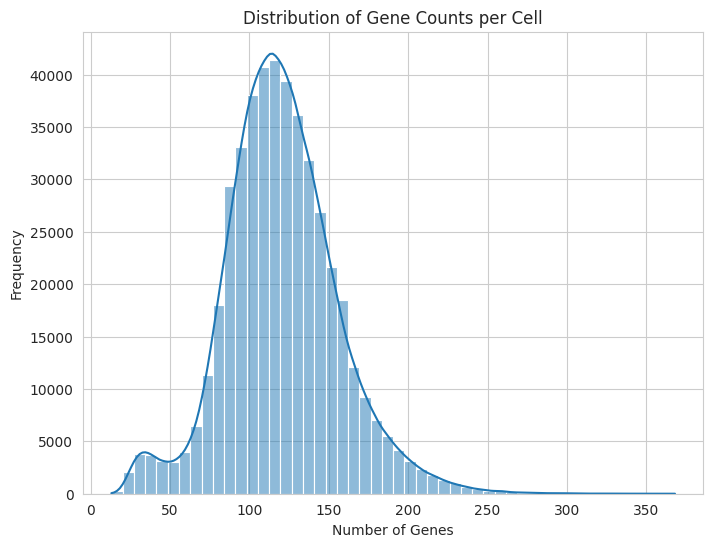

In [106]:
# 2️⃣ Distribution of Genes per Cell
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1)
plt.figure(figsize=(8,6))
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=True)
plt.title("Distribution of Gene Counts per Cell")
plt.xlabel("Number of Genes")
plt.ylabel("Frequency")
plt.show()

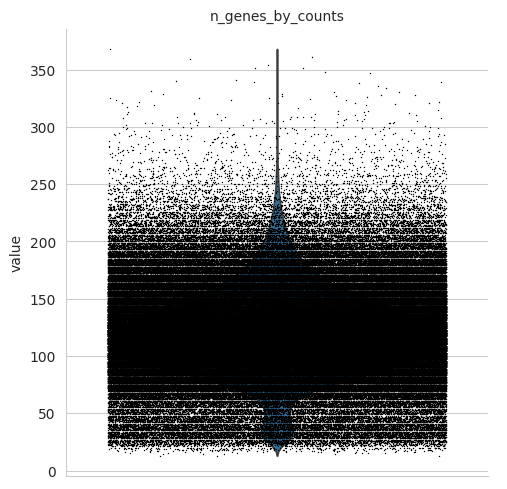

In [107]:
# 3️⃣ Violin Plot of Gene Expression
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, multi_panel=True)

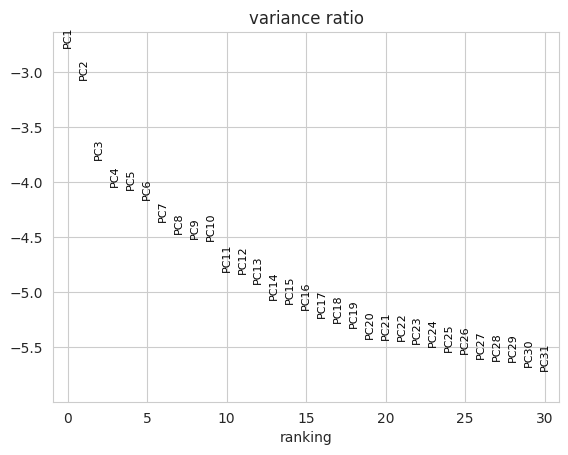

In [108]:
# 4️⃣ PCA for Dimensionality Reduction
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [109]:
# Step 5: Construct Graph Representation
# Convert gene expression data into a graph structure

def build_gene_interaction_graph(adata):
    G = nx.Graph()
    genes = list(adata.var_names)

    # Add nodes (genes)
    for gene in genes:
        G.add_node(gene)

    # Define edges based on correlation (temporary method, can be replaced with known interactions)
    expression_matrix = adata.X.T  # Transpose to have genes as rows
    correlation_matrix = np.corrcoef(expression_matrix)

    threshold = 0.7  # Adjust for significant correlations
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if correlation_matrix[i, j] > threshold:
                G.add_edge(genes[i], genes[j], weight=correlation_matrix[i, j])

    return G

In [110]:
# Build graph
gene_graph = build_gene_interaction_graph(adata)
print(f"Graph constructed with {gene_graph.number_of_nodes()} nodes and {gene_graph.number_of_edges()} edges.")

Graph constructed with 2000 nodes and 218 edges.


In [111]:
# Step 6: Convert Graph to PyTorch Geometric Format

def convert_to_pyg_data(graph):
    node_index = {node: i for i, node in enumerate(graph.nodes())}
    edge_index = []
    edge_attr = []

    for u, v, data in graph.edges(data=True):
        edge_index.append([node_index[u], node_index[v]])
        edge_attr.append(data['weight'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Convert gene expression data into PyTorch tensor
    x = torch.tensor(adata.X, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

In [112]:
# Convert to PyTorch Geometric format
gene_graph_data = convert_to_pyg_data(gene_graph)
print("Graph successfully converted to PyTorch Geometric format!")

Graph successfully converted to PyTorch Geometric format!


In [113]:
# Step 7: Implement Graph Attention Network (GAT)
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=3):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [114]:
# Define Model Parameters
input_dim = gene_graph_data.x.shape[1]
hidden_dim = 64
output_dim = len(set(adata.obs['week_stage']))  # Assuming week_stage as target labels

In [115]:
import torch.optim as optim

In [122]:
# Initialize Model
gat_model = GATModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [123]:
import torch.nn.functional as F

Epoch 0, Loss: 2.9539, Accuracy: 0.0757, Val Loss: 1.8964, Val Accuracy: 0.5556
Epoch 10, Loss: 0.2197, Accuracy: 0.9320, Val Loss: 0.2207, Val Accuracy: 0.9324
Epoch 20, Loss: 0.1061, Accuracy: 0.9653, Val Loss: 0.1187, Val Accuracy: 0.9637
Epoch 30, Loss: 0.0669, Accuracy: 0.9787, Val Loss: 0.0832, Val Accuracy: 0.9755
Epoch 40, Loss: 0.0500, Accuracy: 0.9847, Val Loss: 0.0658, Val Accuracy: 0.9805
Epoch 50, Loss: 0.0405, Accuracy: 0.9885, Val Loss: 0.0557, Val Accuracy: 0.9837
Epoch 60, Loss: 0.0350, Accuracy: 0.9906, Val Loss: 0.0498, Val Accuracy: 0.9853
Epoch 70, Loss: 0.0314, Accuracy: 0.9920, Val Loss: 0.0456, Val Accuracy: 0.9869
Epoch 80, Loss: 0.0290, Accuracy: 0.9930, Val Loss: 0.0430, Val Accuracy: 0.9878
Epoch 90, Loss: 0.0271, Accuracy: 0.9937, Val Loss: 0.0410, Val Accuracy: 0.9884


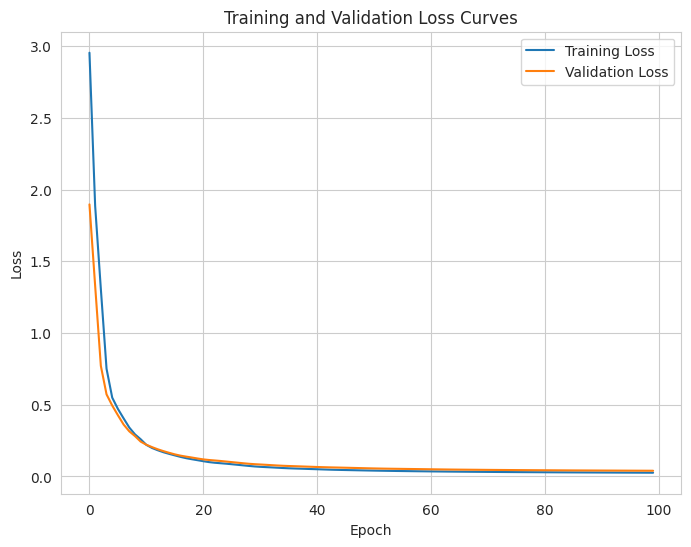

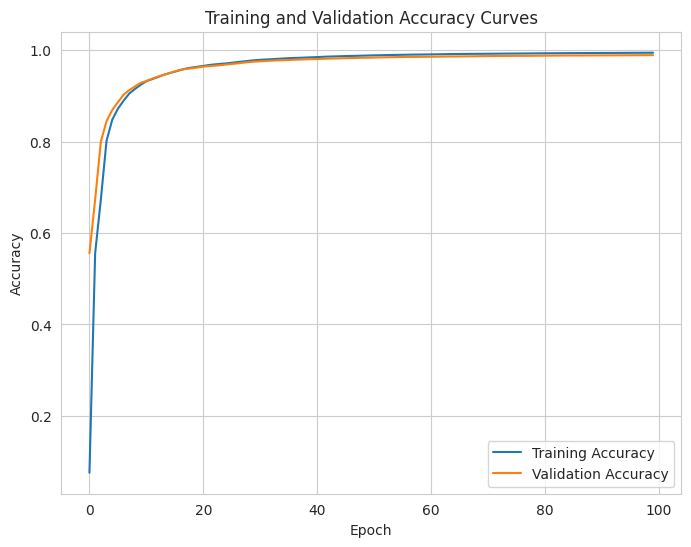

In [125]:
# Step 8: Train GAT Model with Training & Validation Splitting
def train_model(model, data, epochs=100, patience=10):
    model.train()
    encoder = LabelEncoder()

    if 'week_stage_encoded' not in adata.obs.columns:
        adata.obs['week_stage_encoded'] = encoder.fit_transform(adata.obs['week_stage'])

    # Split indices into training (80%) and validation (20%)
    indices = np.arange(len(adata))
    np.random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices, val_indices = indices[:split_idx], indices[split_idx:]

    # Split the dataset into training and validation sets
    train_x = data.x[train_indices]
    val_x = data.x[val_indices]

    train_labels = torch.tensor(adata.obs['week_stage_encoded'].values[train_indices], dtype=torch.long)
    val_labels = torch.tensor(adata.obs['week_stage_encoded'].values[val_indices], dtype=torch.long)

    best_loss = float('inf')
    epochs_without_improvement = 0
    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(Data(x=train_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
        loss = criterion(out, train_labels)
        loss.backward()
        optimizer.step()

        # Store training loss & accuracy
        loss_history.append(loss.item())
        train_preds = out.argmax(dim=1).detach().cpu().numpy()
        train_acc = accuracy_score(train_labels.cpu().numpy(), train_preds)
        accuracy_history.append(train_acc)

        # Validation step
        model.eval()
        with torch.no_grad():
            val_out = model(Data(x=val_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
            val_loss = criterion(val_out, val_labels)
            val_loss_history.append(val_loss.item())
            val_preds = val_out.argmax(dim=1).cpu().numpy()
            val_acc = accuracy_score(val_labels.cpu().numpy(), val_preds)
            val_accuracy_history.append(val_acc)
        model.train()

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {train_acc:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

    return loss_history, accuracy_history, val_loss_history, val_accuracy_history

# Train the model
loss_history, accuracy_history, val_loss_history, val_accuracy_history = train_model(gat_model, gene_graph_data)

# Plot Training vs Validation Curves
plot_loss_curve(loss_history, val_loss_history)
plot_accuracy_curve(accuracy_history, val_accuracy_history)


In [129]:
# Get predictions for the entire dataset
gat_model.eval()  # Set the model to evaluation mode # Changed 'model' to 'gat_model'
with torch.no_grad():
    out = gat_model(gene_graph_data)  # Changed 'model' to 'gat_model' and 'data' to 'gene_graph_data'
    _, predictions = torch.max(out, 1)

In [130]:
# Get true labels for the entire dataset
true_labels = adata.obs['week_stage_encoded'].values

In [131]:
# Compute Accuracy
acc = accuracy_score(true_labels, predictions)
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 0.9934


In [132]:
# Classification Report
print("Classification Report:\n", classification_report(true_labels, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     35901
           1       1.00      1.00      1.00     12530
           2       1.00      1.00      1.00     43079
           3       0.99      0.99      0.99     40878
           4       1.00      1.00      1.00     30038
           5       1.00      1.00      1.00     38833
           6       1.00      1.00      1.00     54269
           7       1.00      1.00      1.00     41811
           8       1.00      1.00      1.00     26610
           9       0.99      0.99      0.99     42080
          10       0.99      0.98      0.99     30495
          11       0.99      0.99      0.99     37979
          12       0.98      0.99      0.98     28217

    accuracy                           0.99    462720
   macro avg       0.99      0.99      0.99    462720
weighted avg       0.99      0.99      0.99    462720



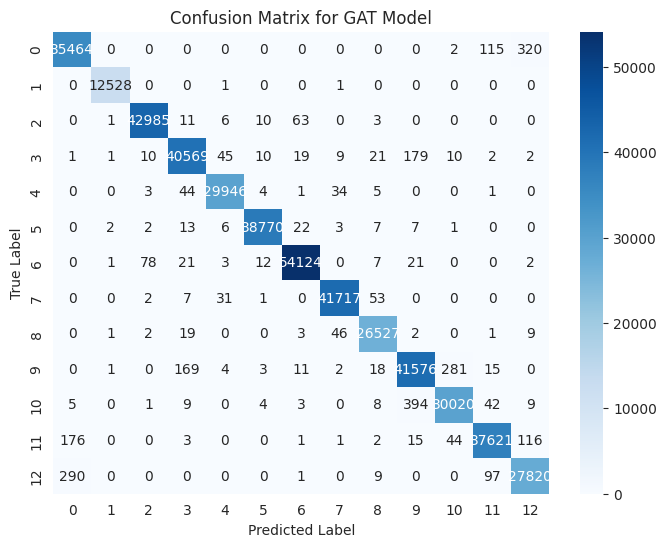

In [133]:
    # Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GAT Model")
    plt.show()

Top 50 Most Important Genes:
               Gene  Importance
24             C1QC    1.000000
23             C1QA    0.480546
1989         MT-ND1    0.398334
92           MLLT11    0.389601
922           STMN2    0.380587
480            GYPB    0.380327
1990         MT-CO1    0.368250
25             C1QB    0.349854
741        HOXA-AS3    0.340715
88           FCGR1A    0.293447
273            TBR1    0.291153
1110           HBG1    0.279956
50           ELAVL4    0.247725
417           CRMP1    0.247052
577           CSF1R    0.244826
1859          FFAR3    0.238022
1633  RP11-445F12.1    0.237612
181           CENPF    0.228605
75             CD53    0.227805
1111           HBE1    0.227364
1551           MT1G    0.226973
57             NFIA    0.225190
501           GPM6A    0.183936
33           LAPTM5    0.181717
842          PCSK1N    0.180101
844           ALAS2    0.174273
415            NSG1    0.173030
856             DCX    0.169385
481            GYPA    0.166488
642        

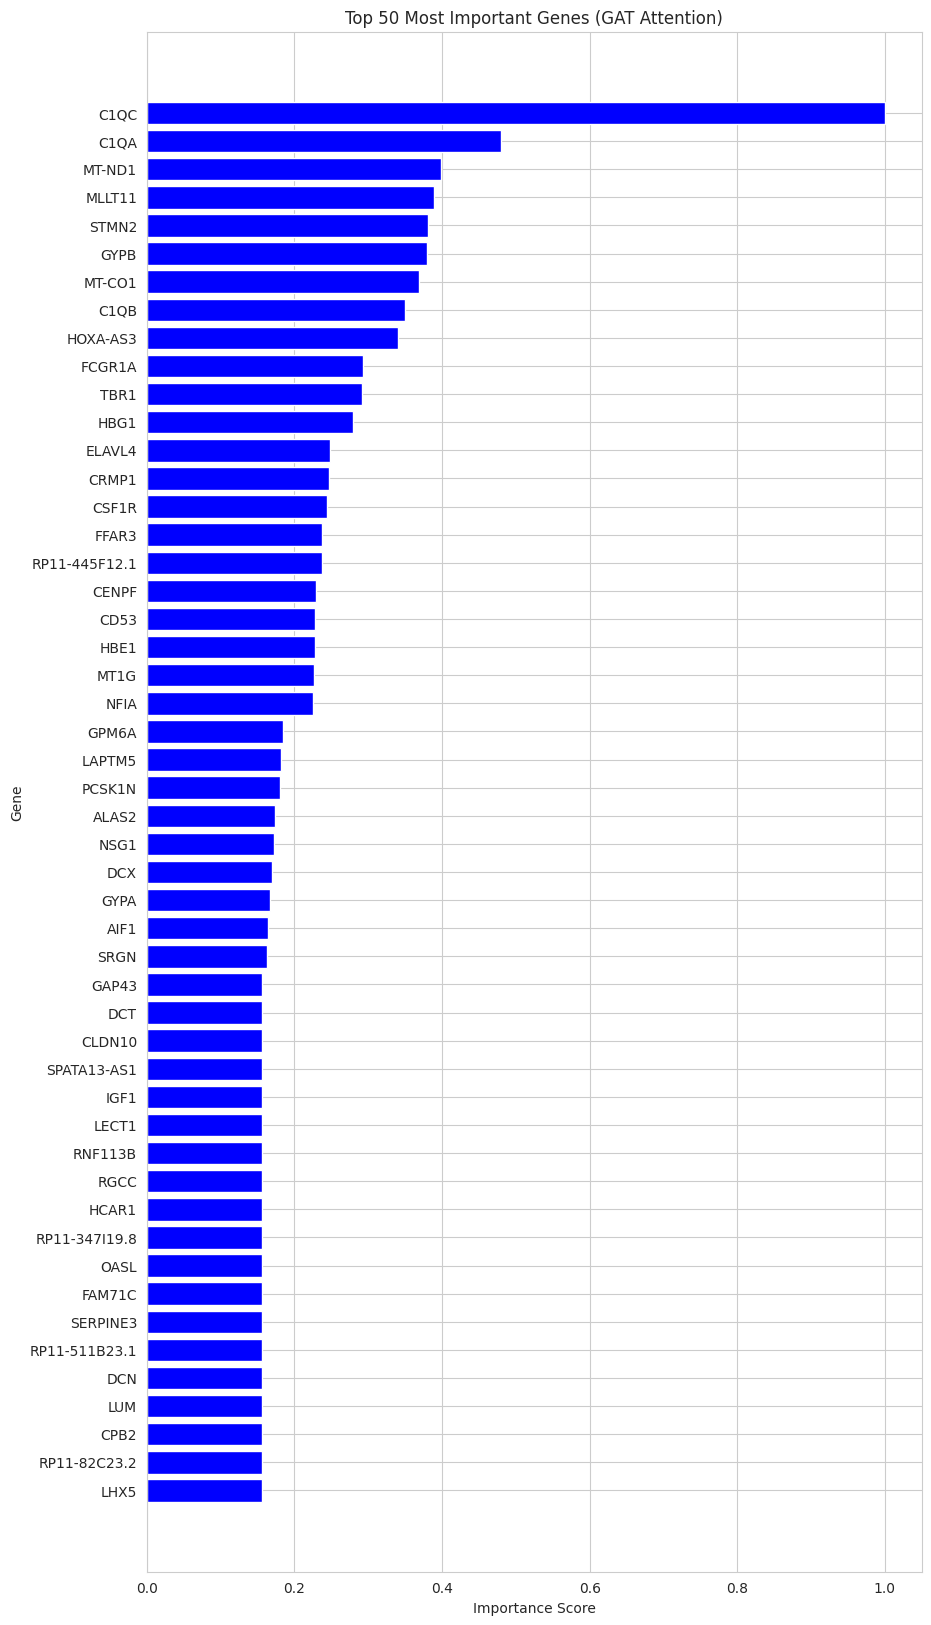

In [148]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract attention weights from GAT
def extract_attention_weights(model, data):
    model.eval()
    with torch.no_grad():
        _, (edge_index, attention_weights) = model.conv1(data.x, data.edge_index, return_attention_weights=True)

    return edge_index.cpu().numpy(), attention_weights.cpu().numpy()

# Extract attention weights
edge_index, attention_weights = extract_attention_weights(gat_model, gene_graph_data)

# If multi-head attention, average over heads
if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
    attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

# Aggregate attention scores per **gene** (not per node)
gene_names = list(adata.var_names)  # 2000 genes
gene_importance = np.zeros(len(gene_names))

# Map node indices to genes
node_to_gene_map = adata.var_names.to_list()  # Ensure genes are correctly mapped

for i in range(edge_index.shape[1]):
    source = edge_index[0, i]  # Source node index
    if source < len(gene_names):  # Ensure mapping only within gene list
        weight = attention_weights[i]
        gene_importance[source] += weight  # Sum attention scores per gene

# Normalize importance scores
gene_importance /= np.max(gene_importance)  # Normalize to range [0, 1]

# Create DataFrame with gene names and importance
gene_importance_df = pd.DataFrame({"Gene": gene_names, "Importance": gene_importance})
gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False)

# Display top 50 most important genes
print("Top 50 Most Important Genes:")
print(gene_importance_df.head(50))

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(gene_importance_df["Gene"][:50], gene_importance_df["Importance"][:50], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Gene")
plt.title("Top 50 Most Important Genes (GAT Attention)")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


In [135]:
import pandas as pd
import torch

# Get unique weeks
unique_weeks = adata.obs['week_stage'].unique()

# Dictionary to store results
top_genes_per_week = {}

# Iterate through each week
for week in unique_weeks:
    print(f"Processing Week: {week}")

    # Subset data for the current week
    week_mask = adata.obs['week_stage'] == week

    # Create a new Data object with the subsetted data and original graph structure
    week_data = Data(x=gene_graph_data.x[week_mask],
                     edge_index=gene_graph_data.edge_index,
                     edge_attr=gene_graph_data.edge_attr)

    # Get attention scores for this week
    with torch.no_grad():
        gat_output = gat_model(week_data)  # Run GAT on the week's data

        # Get attention weights from the first GATConv layer
        _, (edge_index, attention_weights) = gat_model.conv1(week_data.x, week_data.edge_index, return_attention_weights=True)
        attention_weights = attention_weights.cpu().numpy()

        # If multi-head attention, average over heads
        if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
            attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

        # Aggregate attention scores per gene
        gene_importance = np.zeros(len(adata.var_names))
        for i in range(edge_index.shape[1]):
            source = edge_index[0, i].item()  # Get source node index as an integer
            if source < len(adata.var_names):
                gene_importance[source] += attention_weights[i]

        # Normalize importance scores
        gene_importance /= np.max(gene_importance) if np.max(gene_importance) != 0 else 1  # Avoid division by zero


    # Create DataFrame of genes and importance
    gene_importance_df = pd.DataFrame({
        "Gene": adata.var_names,
        "Importance": gene_importance
    })

    # Sort and select top 20
    gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False).head(20)

    # Store results
    top_genes_per_week[week] = gene_importance_df

# Display results
for week, df in top_genes_per_week.items():
    print(f"\nTop 20 Genes for Week {week}")
    print(df)

Processing Week: W3-1


<ipython-input-135-ac1088f67c33>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_data = Data(x=gene_graph_data.x[week_mask],


Processing Week: W4-1
Processing Week: W4-2
Processing Week: W4-3
Processing Week: W5-1
Processing Week: W5-2
Processing Week: W5-3
Processing Week: W6-1
Processing Week: W7-1
Processing Week: W8-1
Processing Week: W9-1
Processing Week: W9-2
Processing Week: W12-1

Top 20 Genes for Week W3-1
               Gene  Importance
24             C1QC    1.000000
23             C1QA    0.480546
1989         MT-ND1    0.398334
92           MLLT11    0.389601
922           STMN2    0.380587
480            GYPB    0.380327
1990         MT-CO1    0.368250
25             C1QB    0.349854
741        HOXA-AS3    0.340715
88           FCGR1A    0.293447
273            TBR1    0.291153
1110           HBG1    0.279956
50           ELAVL4    0.247725
417           CRMP1    0.247052
577           CSF1R    0.244826
1859          FFAR3    0.238022
1633  RP11-445F12.1    0.237612
181           CENPF    0.228605
75             CD53    0.227805
1111           HBE1    0.227364

Top 20 Genes for Week W4-1
       

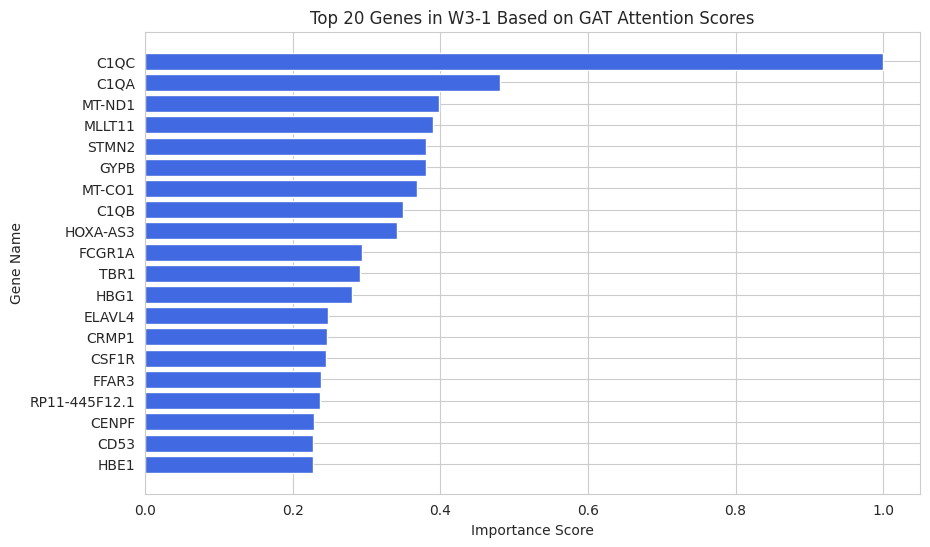

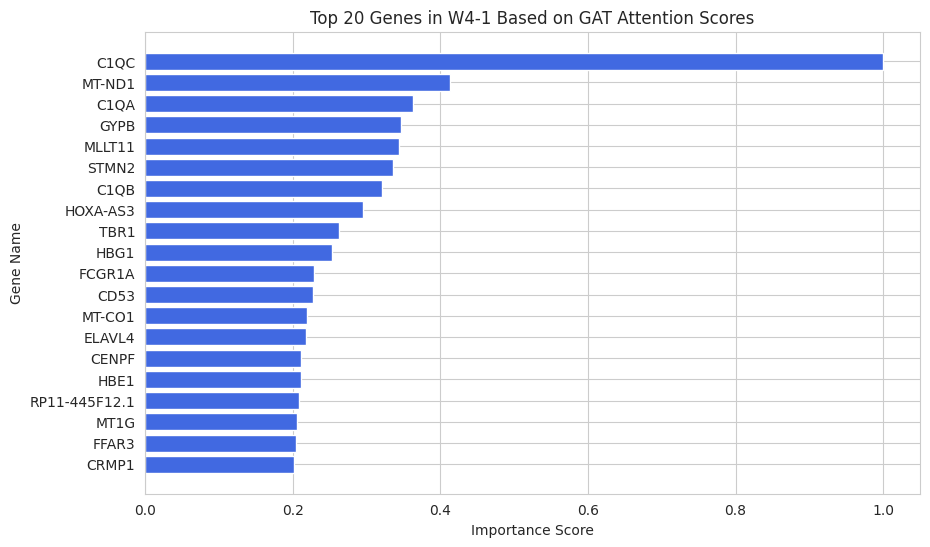

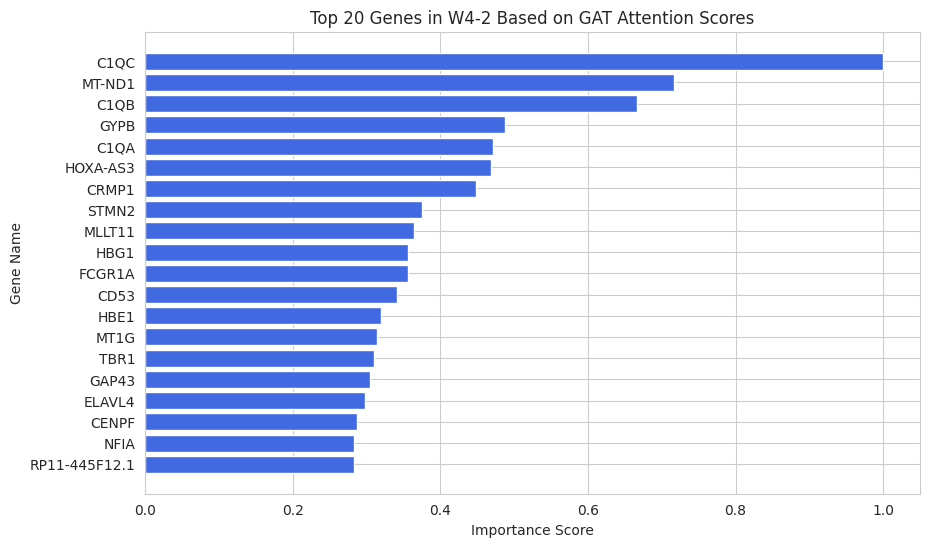

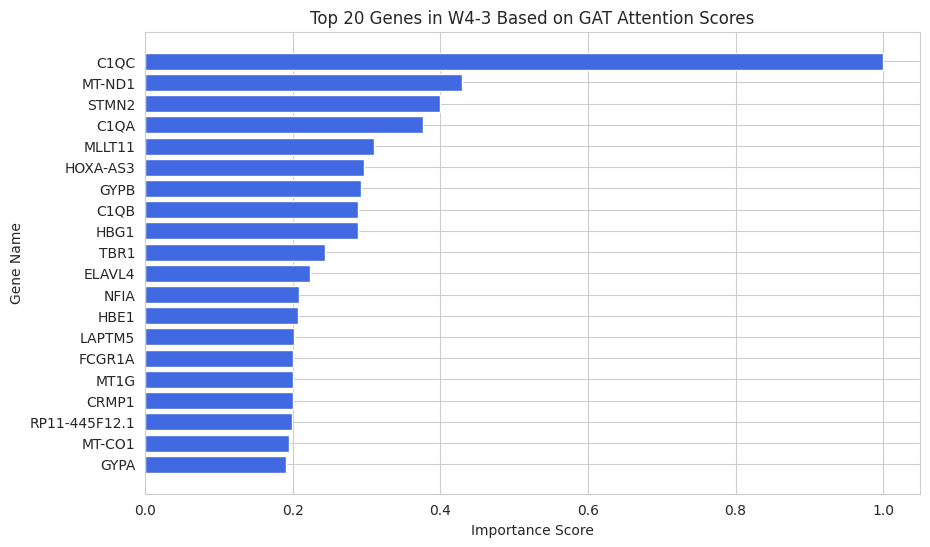

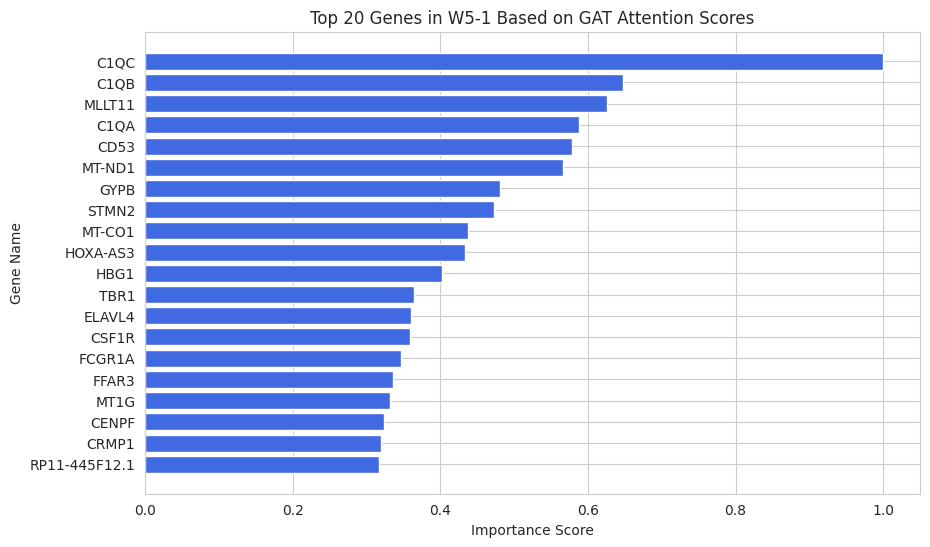

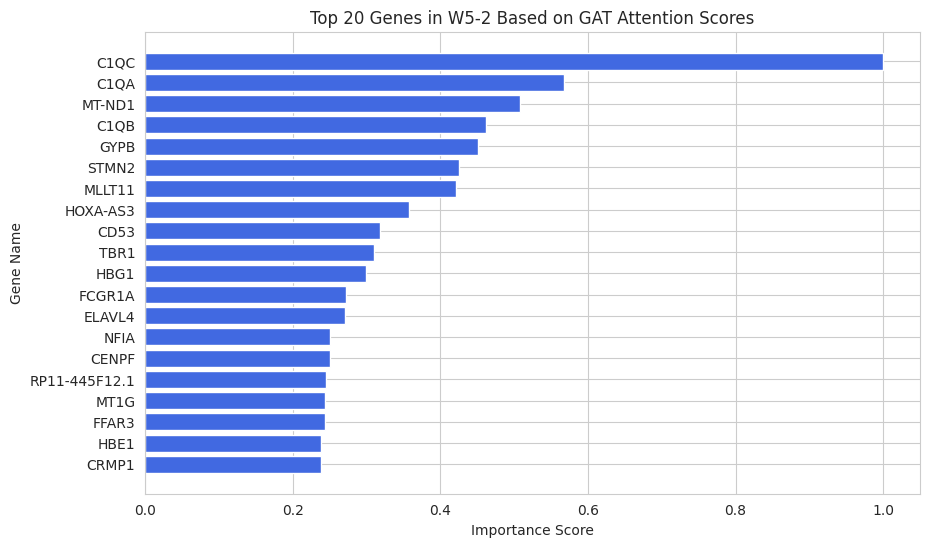

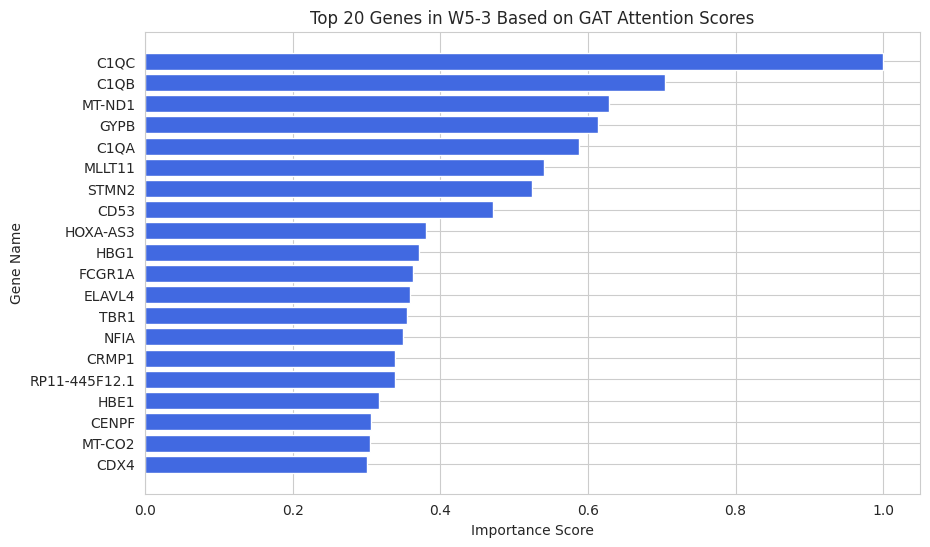

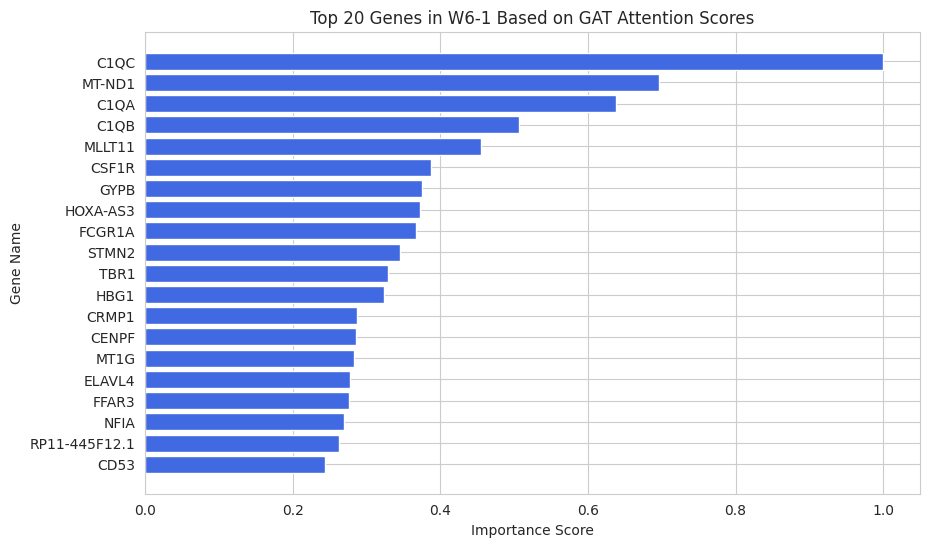

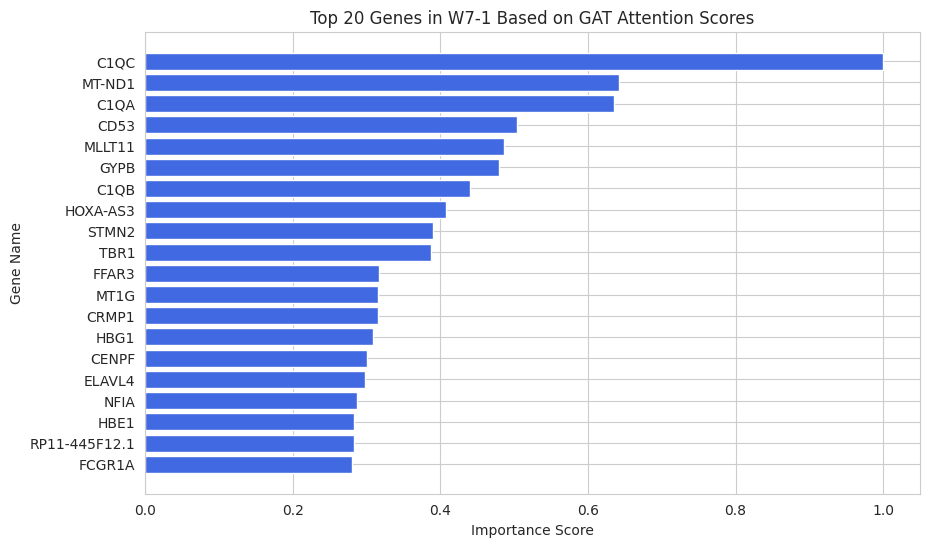

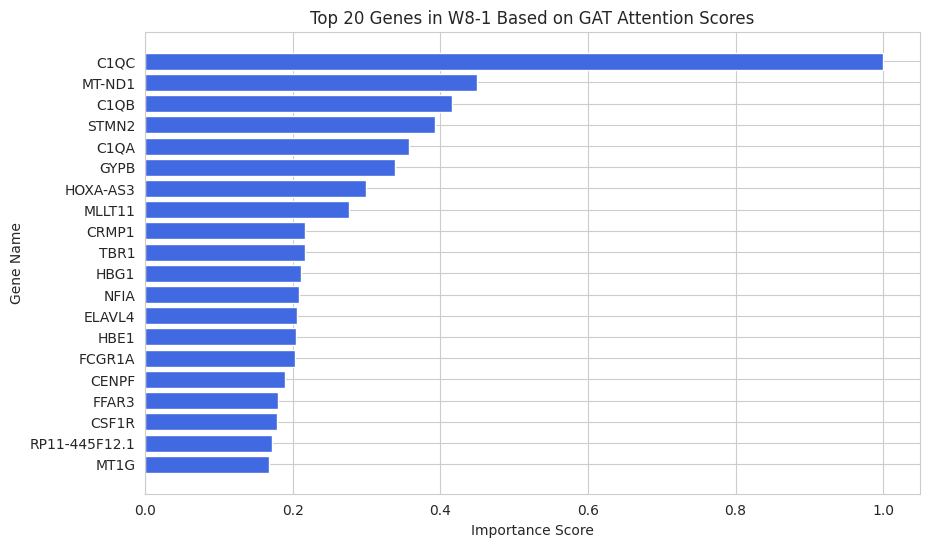

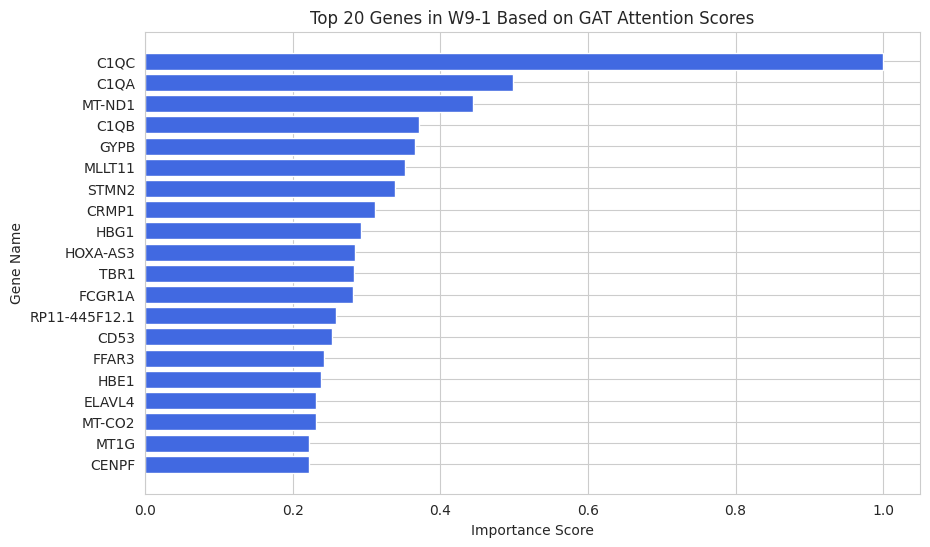

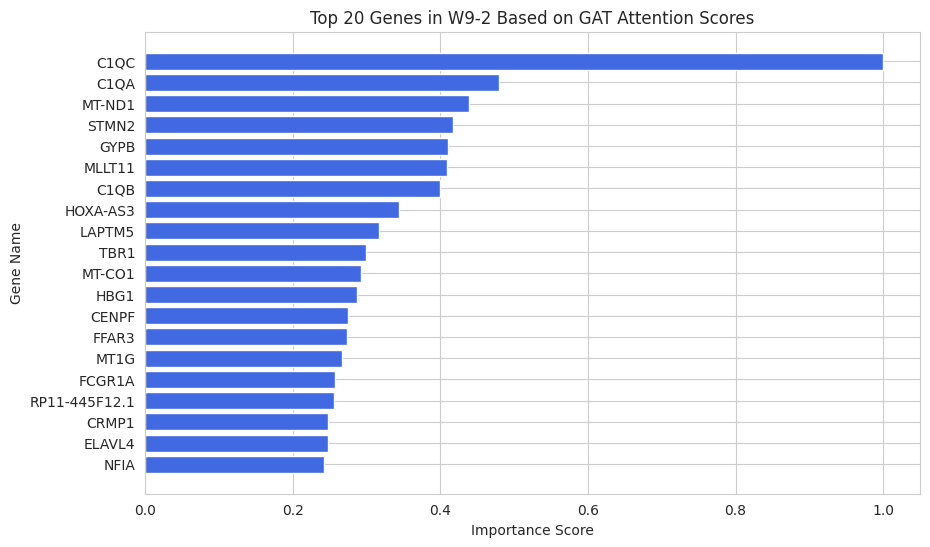

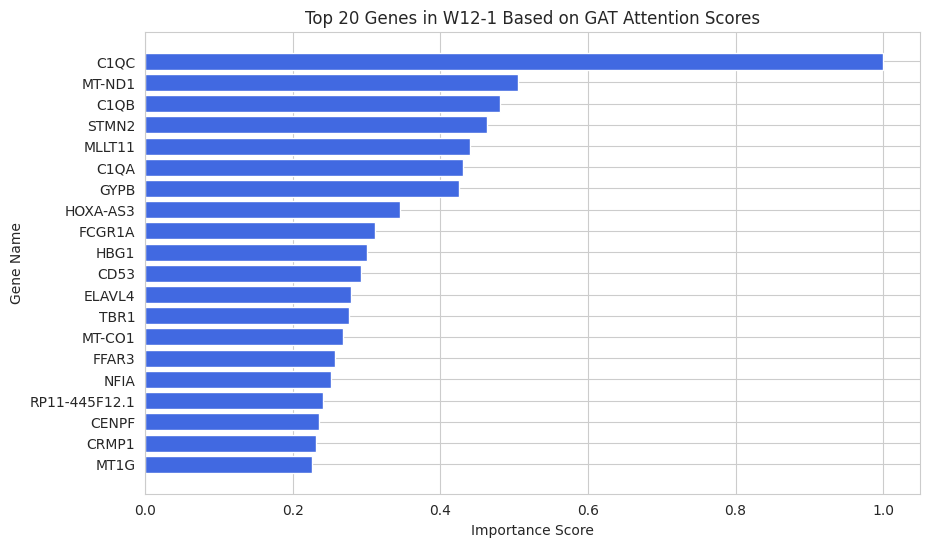

In [136]:
def plot_top_genes_bar(top_genes_per_week):
    for week, df in top_genes_per_week.items():
        plt.figure(figsize=(10, 6))
        plt.barh(df["Gene"], df["Importance"], color="royalblue")
        plt.xlabel("Importance Score")
        plt.ylabel("Gene Name")
        plt.title(f"Top 20 Genes in {week} Based on GAT Attention Scores")
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.show()

# Call the function with your data
plot_top_genes_bar(top_genes_per_week)

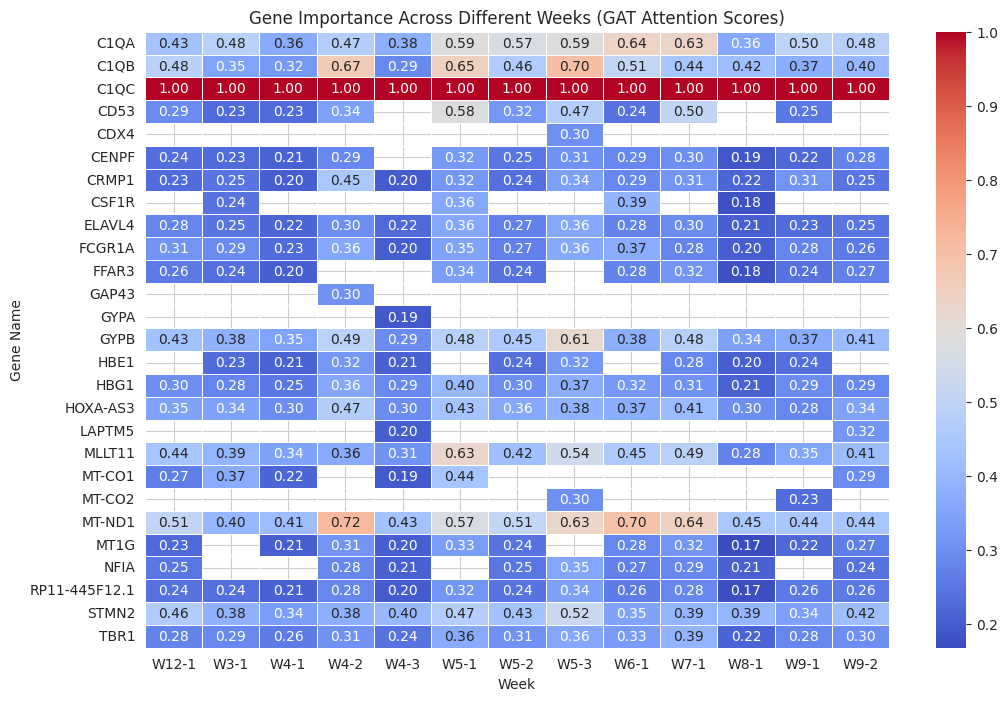

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dictionary of DataFrames to one combined DataFrame
heatmap_data = pd.concat(top_genes_per_week, names=["Week"]).reset_index()

# Pivot the DataFrame for heatmap format
heatmap_pivot = heatmap_data.pivot(index="Gene", columns="Week", values="Importance")

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Gene Importance Across Different Weeks (GAT Attention Scores)")
plt.xlabel("Week")
plt.ylabel("Gene Name")
plt.show()


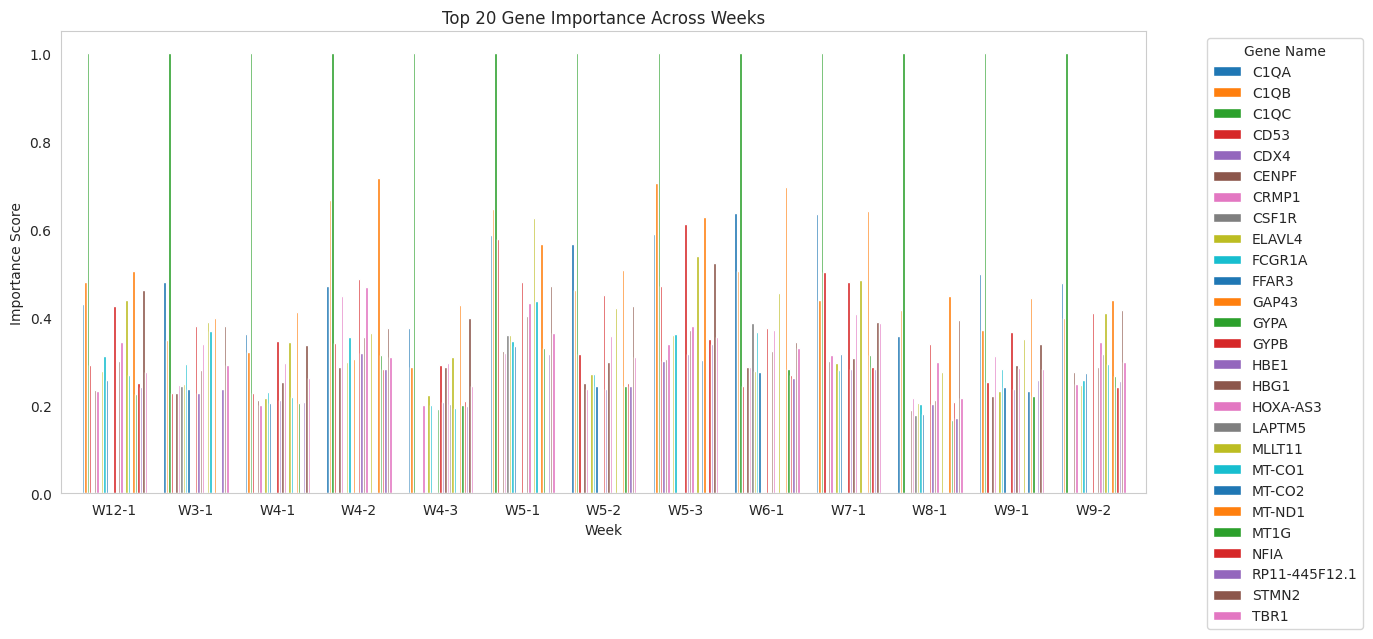

In [139]:
# Plot grouped bar chart
heatmap_pivot.T.plot(kind="bar", figsize=(14, 6), width=0.8)
plt.xlabel("Week")
plt.ylabel("Importance Score")
plt.title("Top 20 Gene Importance Across Weeks")
plt.xticks(rotation=0)
plt.legend(title="Gene Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()


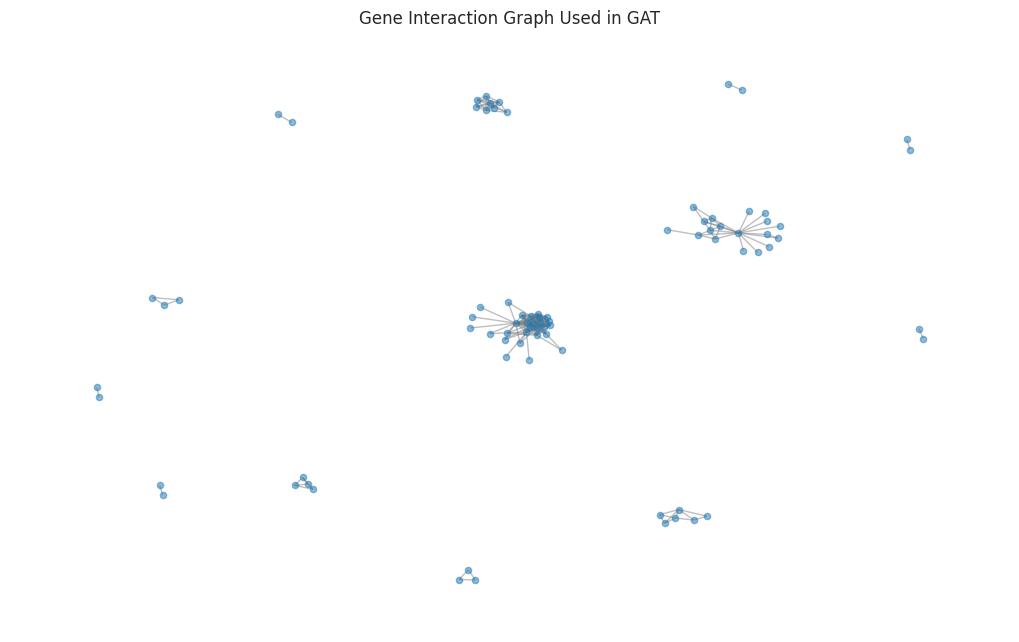

In [138]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert PyTorch Geometric graph to NetworkX for visualization
def visualize_graph(graph_data):
    G = nx.Graph()

    # Add nodes and edges
    edge_index = graph_data.edge_index.cpu().numpy()
    G.add_edges_from(zip(edge_index[0], edge_index[1]))

    plt.figure(figsize=(10, 6))
    nx.draw(G, node_size=20, edge_color="gray", alpha=0.5)
    plt.title("Gene Interaction Graph Used in GAT")
    plt.show()

# Call the function
visualize_graph(gene_graph_data)


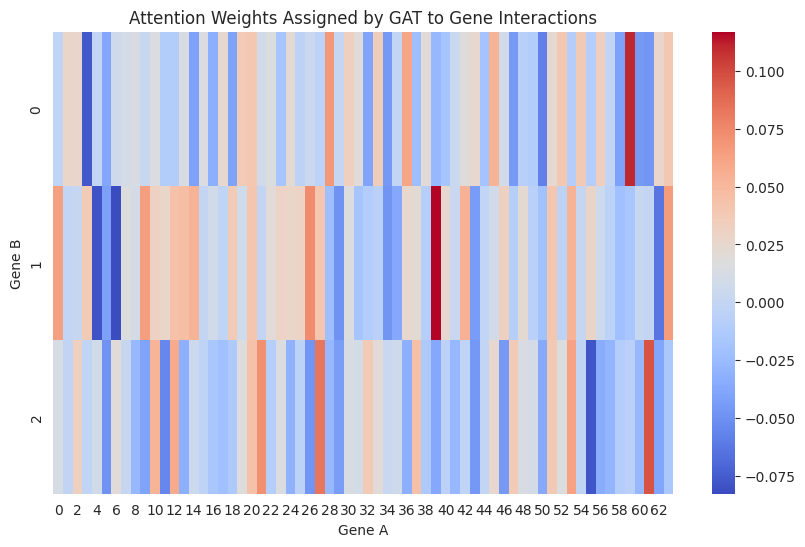

In [140]:
import seaborn as sns
import numpy as np

# Extract attention weights from first GAT layer
gat_layer = gat_model.conv1
attention_weights = gat_layer.att_src.cpu().detach().numpy()

# Reshape or reduce the dimensions of attention_weights
# Option 1: Average over the first dimension
attention_weights = np.mean(attention_weights, axis=0)

# Option 2: Select a specific head (e.g., the first head)
# attention_weights = attention_weights[0]

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(attention_weights, cmap="coolwarm", annot=False)
plt.title("Attention Weights Assigned by GAT to Gene Interactions")
plt.xlabel("Gene A")
plt.ylabel("Gene B")
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


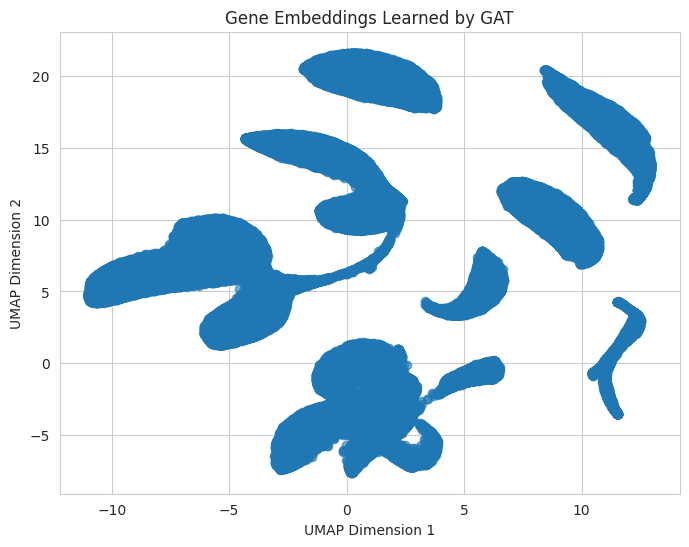

In [141]:
from umap import UMAP
import matplotlib.pyplot as plt
import torch

# Get embeddings from the output of the GAT model
gat_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    gat_output = gat_model(gene_graph_data)  # Pass your data to the model

# Assuming gat_output contains the node embeddings, usually in the shape (num_nodes, embedding_dim)
gat_embeddings = gat_output.cpu().detach().numpy()

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
embeddings_2d = umap.fit_transform(gat_embeddings)

# Scatter plot of gene embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Gene Embeddings Learned by GAT")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


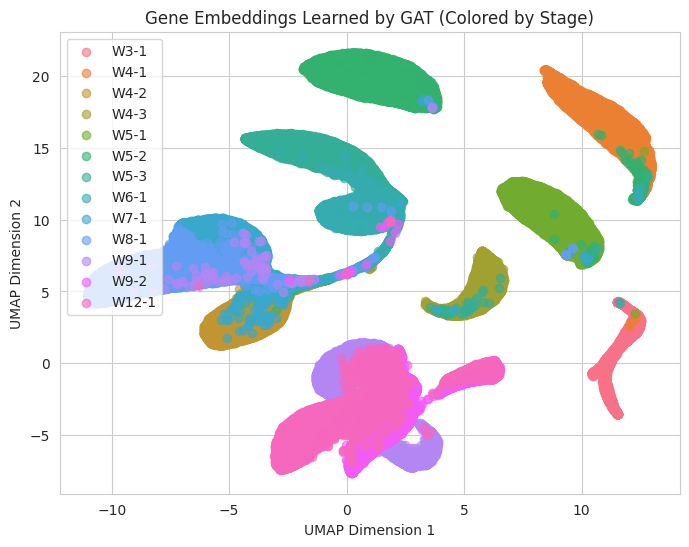

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have 'week_stage' in adata.obs and embeddings_2d
cluster_labels = adata.obs['week_stage']
unique_clusters = cluster_labels.unique()

# Create stage names (replace with your desired names)
stage_names = {
    "week_stage_value1": "Stage 1",
    "week_stage_value2": "Stage 2",
    "week_stage_value3": "Stage 3",
    # ... add more mappings as needed
}

# Create color palette (same as before)
num_clusters = len(unique_clusters)
palette = sns.color_palette("husl", num_clusters)
cluster_color_map = dict(zip(unique_clusters, palette))

# Color the UMAP plot with stage names
plt.figure(figsize=(8, 6))
for cluster in unique_clusters:
    cluster_indices = cluster_labels == cluster
    plt.scatter(
        embeddings_2d[cluster_indices, 0],
        embeddings_2d[cluster_indices, 1],
        color=cluster_color_map[cluster],
        label=stage_names.get(cluster, cluster),  # Use stage name if available, otherwise use original label
        alpha=0.6,
    )

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Gene Embeddings Learned by GAT (Colored by Stage)")
plt.legend()
plt.show()

#clusters of cells